# TABLE OF CONTENTS:
---
* [Setup](#Setup)
    * [Connect to Workspace](#Connect-to-Workspace)
* [Retrieve the Registered Model](#Retrieve-the-Registered-Model)
* [Retrieve the Registered Inference Environment](#Retrieve-the-Registered-Inference-Environment)
* [Inference Artifacts & Configuration](#Inference-Artifacts-&-Configuration)
* [Model Deployment (Local)](#Model-Deployment-(Local))
* [Model Deployment (Compute Target)](#Model-Deployment-(Compute-Target))
    * [Option 1: Deploy to ACI Container](#Option-1:-Deploy-to-ACI-Container)
    * [Option 2: Deploy to ASK](#Option-2:-Deploy-to-AKS)
* [Model Deployment (Container Image)](#Model-Deployment-(Container-Image))  
    * [Package Models](#Package-Models)
* [Model Webservice Testing](#Model-Webservice-Testing)
    * [Python SDK](#Python-SDK)
    * [Send HTTP Request](#Send-HTTP-Request)
* [Resource Clean Up](#Resource-Clean-Up)
---

# Setup

Append parent directory to sys path to be able to import created modules from src directory.

In [15]:
import sys
sys.path.append(os.path.dirname(os.path.abspath("")))

In [37]:
# Import libraries
import json
import matplotlib.pyplot as plt
import numpy as np
import requests
import torch
import torchvision
import torchvision.transforms as transforms
import uuid
from azureml.core import Environment, Workspace
from azureml.core.compute import AksCompute, ComputeTarget
from azureml.core.compute_target import ComputeTargetException
from azureml.core.container_registry import RegistryIdentity
from azureml.core.model import InferenceConfig, Model
from azureml.core.webservice import AciWebservice, AksWebservice, Webservice
from PIL import Image

# Import created modules
from src.training.data_utils import preprocess_image

### Connect to Workspace

In order to connect and communicate with the Azure Machine Learning (AML) workspace, a workspace object needs to be instantiated using the Azure ML SDK.

In [2]:
# Connect to the AML workspace. MsiAuthenthication only works out of the box on the AML Compute Instance.
# For alternative connection options see the aml_snippets directory.
msi_auth = MsiAuthentication()

ws = Workspace(subscription_id="bf088f59-f015-4332-bd36-54b988be7c90",
               resource_group="amlbrikserg",
               workspace_name="amlbriksews",
               auth=msi_auth)

# Retrieve the Registered Model

Retrieve the registered model from the workspace.

In [3]:
model_name = "fowl-model"
model = Model(workspace=ws, name=model_name)

In [4]:
# model_name = "cifar10-model"
# model = Model(workspace=ws, name=model_name)

# Retrieve the Registered Inference Environment

Retrieve the inferencing environment from the workspace. In order to get to know more about options on how to create an environment, see the aml_snippets directory.

In [4]:
env_name = "pytorch-aml-env"
env = Environment.get(workspace=ws, name=env_name)

# Inference Artifacts & Configuration

Create a deployment directory for artifacts that are required for inference.

In [5]:
deployment_folder = os.path.join("../src/", "deployment")
os.makedirs(deployment_folder, exist_ok=True)

Create the scoring script, called score.py, used by the web service call to show how to use the model.

Two functions are required in the scoring script:
1. an `init` function that executes once when the service starts - in this function you normally get the model from the registry and set global variables
1. a `run(data)` function that executes each time a call is made to the service. In this function, you normally deserialize the json, run a prediction and output the predicted result.

In [6]:
%%writefile $deployment_folder/score.py
# Import libraries
import json
import os
import torch
import torch.nn as nn
from azureml.core.model import Model
from torchvision import transforms


def init():
    global model
    # AZUREML_MODEL_DIR is an environment variable created during deployment.
    # It is the path to the model folder (./azureml-models/$MODEL_NAME/$VERSION)
    # For multiple models, it points to the folder containing all deployed models (./azureml-models)
    model_path = os.path.join(os.getenv("AZUREML_MODEL_DIR"), "model.pt")
    model = torch.load(model_path, map_location=lambda storage, loc: storage)
    model.eval()


def run(input_data):
    input_data = torch.tensor(json.loads(input_data)["data"])

    # get prediction
    with torch.no_grad():
        output = model(input_data)
        classes = ["chicken", "turkey"]
        softmax = nn.Softmax(dim=1)
        pred_probs = softmax(output).numpy()[0]
        index = torch.argmax(output, 1)

    result = {"label": classes[index], "probability": str(pred_probs[index])}
    return result

Overwriting ../src/deployment/score.py


In [7]:
# %%writefile $deployment_folder/score.py
# import os
# import torch
# import json
# import torch.nn as nn
# import torch.nn.functional as F


# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         self.conv1 = nn.Conv2d(3, 6, 5)
#         self.pool = nn.MaxPool2d(2, 2)
#         self.conv2 = nn.Conv2d(6, 16, 5)
#         self.fc1 = nn.Linear(16 * 5 * 5, 120)
#         self.fc2 = nn.Linear(120, 84)
#         self.fc3 = nn.Linear(84, 10)

#     def forward(self, x):
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.pool(F.relu(self.conv2(x)))
#         x = x.view(-1, 16 * 5 * 5)
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x


# def init():
#     global net
#     global classes

#     # AZUREML_MODEL_DIR is an environment variable created during deployment.
#     # It is the path to the model folder (./azureml-models/$MODEL_NAME/$VERSION)
#     # For multiple models, it points to the folder containing all deployed models (./azureml-models)
#     model_filename = "cifar_net.pt"
#     model_path = os.path.join(os.environ['AZUREML_MODEL_DIR'], model_filename)
#     net = Net()
#     net.load_state_dict(torch.load(model_path))
#     classes = ('plane', 'car', 'bird', 'cat',
#                'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


# def run(data):
#     data = json.loads(data)
#     images = torch.FloatTensor(data['data'])
#     outputs = net(images)

#     _, predicted = torch.max(outputs, 1)

#     result = [classes[predicted[j]] for j in range(4)]
#     result_json = json.dumps({"predictions": result})

#     # You can return any JSON-serializable object.
#     return result_json

Overwriting ../src/deployment/score.py


In [7]:
# Create Inference Config
inference_config = InferenceConfig(entry_script="../src/deployment/score.py",
                                   environment=env)

# Model Deployment (Local)

# Model Deployment (Compute Target)

### Option 1: Deploy to ACI Container

In [38]:
aci_service_name = "fowl-pytorch-aci-service"

aci_config = AciWebservice.deploy_configuration(cpu_cores=1,
                                                memory_gb=1,
                                                tags={"data": "birds", "method": "transfer learning", "framework": "pytorch"},
                                                description="Classify turkey/chickens using transfer learning with PyTorch")

service = Model.deploy(workspace=ws,
                       name=aci_service_name,
                       models=[model],
                       inference_config=inference_config,
                       deployment_config=aci_config)

service.wait_for_deployment(True)
print(service.state)

Tips: You can try get_logs(): https://aka.ms/debugimage#dockerlog or local deployment: https://aka.ms/debugimage#debug-locally to debug if deployment takes longer than 10 minutes.
Running...................................................
Succeeded
ACI service creation operation finished, operation "Succeeded"
Healthy


### Option 2: Deploy to AKS

Provision an AKS Cluster.

In [24]:
aks_name = "aks-cluster" 

# Retrieve all computes from workspace
cts = ws.compute_targets

# Use existing cluster if available, else create a new one
if aks_name in cts and cts[aks_name].type == "AKS":
    print("Found existing AKS cluster, will use it!")
    aks_target = cts[aks_name]
else:
    print("Creating a new AKS cluster...")
    # Use the default provisioning config (no input parameters) or provide parameters to customize
    # For example, to create a dev/test cluster, use:
    prov_config = AksCompute.provisioning_configuration(cluster_purpose = AksCompute.ClusterPurpose.DEV_TEST)
    # Example configuration to use an existing virtual network
    # prov_config.vnet_name = "mynetwork"
    # prov_config.vnet_resourcegroup_name = "myresourcegroup"
    # prov_config.subnet_name = "default"
    # prov_config.service_cidr = "10.0.0.0/16"
    # prov_config.dns_service_ip = "10.0.0.10"
    # prov_config.docker_bridge_cidr = "172.17.0.1/16"
    aks_target = ComputeTarget.create(workspace = ws,
                                      name = aks_name,
                                      provisioning_configuration = prov_config)
    
    print("Waiting for cluster creation completion...")
    aks_target.wait_for_completion(show_output=True)

print("Cluster state:", aks_target.provisioning_state)
print("Cluster is ready!", aks_target)

Creating a new AKS cluster...
Waiting for cluster creation completion...
Creating.........................................................................................................................................................
SucceededProvisioning operation finished, operation "Succeeded"
Cluster state: Succeeded
Cluster is ready! AksCompute(workspace=Workspace.create(name='amlbriksews', subscription_id='bf088f59-f015-4332-bd36-54b988be7c90', resource_group='amlbrikserg'), name=aks-cluster, id=/subscriptions/bf088f59-f015-4332-bd36-54b988be7c90/resourceGroups/amlbrikserg/providers/Microsoft.MachineLearningServices/workspaces/amlbriksews/computes/aks-cluster, type=AKS, provisioning_state=Succeeded, location=westeurope, tags=None)


In [33]:
aks_service_name = "fowl-pytorch-aks-service"

aks_config = AksWebservice.deploy_configuration(
                                                collect_model_data=True,
                                                enable_app_insights=True)

aks_webservices = Webservice.list(workspace = ws, compute_type="AKS")

if any(aks_webservice.name == aks_service_name for aks_webservice in aks_webservices):
    print("Model with same name already deployed")
else:
    if aks_target.provisioning_state == "Succeeded":
        service = Model.deploy(workspace=ws,
                               name=aks_service_name,
                               models=[model],
                               inference_config=inference_config,
                               deployment_config=aks_config,
                               deployment_target=aks_target)
        
        service.wait_for_deployment(show_output = True)
        print("Service state:", service.state)
        print("Service details:", service)
    else: 
        raise ValueError("Failed to deploy service to AKS - Error: ", service.error)

Tips: You can try get_logs(): https://aka.ms/debugimage#dockerlog or local deployment: https://aka.ms/debugimage#debug-locally to debug if deployment takes longer than 10 minutes.
Running..................................................
Succeeded
AKS service creation operation finished, operation "Succeeded"
Service state: Healthy
Service details: AksWebservice(workspace=Workspace.create(name='amlbriksews', subscription_id='bf088f59-f015-4332-bd36-54b988be7c90', resource_group='amlbrikserg'), name=fowl-pytorch-aks-service, image_id=None, compute_type=None, state=AKS, scoring_uri=Healthy, tags=http://23.101.72.193:80/api/v1/service/fowl-pytorch-aks-service/score, properties={}, created_by={'azureml.git.repository_uri': 'https://github.com/sebastianbirk/pytorch-use-cases-azure-ml', 'mlflow.source.git.repoURL': 'https://github.com/sebastianbirk/pytorch-use-cases-azure-ml', 'azureml.git.branch': 'master', 'mlflow.source.git.branch': 'master', 'azureml.git.commit': 'a462df57f0cb447cd73e127

If something goes wrong with the deployment, the first thing to look at is the logs from the service by running the following command:

In [ ]:
service.get_logs()

Get the web service's HTTP endpoint, which accepts REST client calls. This endpoint can be integrated into any application.

In [ ]:
scoring_uri = service.scoring_uri
print(scoring_uri)

# Model Deployment (Container Image)

### Package Models

[Package a registered model with docker](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-deploy-package-models):

In some cases, you might want to create a Docker image without deploying the model (if, for example, you plan to deploy to Azure App Service). Or you might want to download the image and run it on a local Docker installation. You might even want to download the files used to build the image, inspect them, modify them, and build the image manually.

Model packaging enables you to do these things. It packages all the assets needed to host a model as a web service and allows you to download either a fully built Docker image or the files needed to build one. There are two ways to use model packaging:

**Download a packaged model:** Download a Docker image that contains the model and other files needed to host it as a web service.

**Generate a Dockerfile:** Download the Dockerfile, model, entry script, and other assets needed to build a Docker image. You can then inspect the files or make changes before you build the image locally.

Creating a package is similar to deploying a model. You use a registered model and an inference configuration. The following code builds an image, which is registered in the Azure Container Registry for your workspace.

If the generate_dockerfile flag is set to False, then an ACR build task will be triggered and the image will be built on the workspace-native ACR.

In [23]:
image_name = "inference/fowl-pytorch"
image_label = "1.0" # image tag
generate_dockerfile = False # Option 1: False -> Build Image on ACR
# generate_dockerfile = True # Option 2: True -> Only create Dockerfile

# Creating package
package = Model.package(ws, 
                        [model], 
                        inference_config=inference_config, 
                        generate_dockerfile=generate_dockerfile,
                        image_name=image_name,
                        image_label=image_label)

package.wait_for_creation(show_output=True)

2021/01/26 12:53:31 Downloading source code...
2021/01/26 12:53:33 Finished downloading source code
2021/01/26 12:53:34 Creating Docker network: acb_default_network, driver: 'bridge'
2021/01/26 12:53:34 Successfully set up Docker network: acb_default_network
2021/01/26 12:53:34 Setting up Docker configuration...
2021/01/26 12:53:35 Successfully set up Docker configuration
2021/01/26 12:53:35 Logging in to registry: 3d5545b15c4c49548d3823156fa90536.azurecr.io
2021/01/26 12:53:36 Successfully logged into 3d5545b15c4c49548d3823156fa90536.azurecr.io
2021/01/26 12:53:36 Executing step ID: acb_step_0. Timeout(sec): 5400, Working directory: '', Network: 'acb_default_network'
2021/01/26 12:53:36 Launching container with name: acb_step_0
WARNING! Using --password via the CLI is insecure. Use --password-stdin.
WARNING! Your password will be stored unencrypted in /acb/home/.docker/config.json.
Configure a credential helper to remove this warning. See
https://docs.docker.com/engine/reference/comma

 ---> Running in b09d415a03d1
Removing intermediate container b09d415a03d1
 ---> 5ef674ea86df
Step 6/7 : RUN mv '/var/azureml-app/tmp15v99c80.py' /var/azureml-app/main.py
 ---> Running in 46b87065fb9b
Removing intermediate container 46b87065fb9b
 ---> efd962098dd8
Step 7/7 : CMD ["runsvdir","/var/runit"]
 ---> Running in 11507ca08ce2
Removing intermediate container 11507ca08ce2
 ---> 4a780c682fdf
Successfully built 4a780c682fdf
Successfully tagged 3d5545b15c4c49548d3823156fa90536.azurecr.io/azureml/azureml_88dfe21f94ac58d8e8fdc09d24a81c70:latest
2021/01/26 12:56:50 Successfully executed container: acb_step_1
2021/01/26 12:56:50 Executing step ID: acb_step_2. Timeout(sec): 5400, Working directory: '', Network: 'acb_default_network'
2021/01/26 12:56:50 Pushing image: 3d5545b15c4c49548d3823156fa90536.azurecr.io/azureml/azureml_88dfe21f94ac58d8e8fdc09d24a81c70:latest, attempt 1
The push refers to repository [3d5545b15c4c49548d3823156fa90536.azurecr.io/azureml/azureml_88dfe21f94ac58d8e8fdc0

# Model Webservice Testing

Let's test our deployed web service. We will send the data as a JSON string to the web service hosted in ACI and use the SDK's run API to invoke the service. Here we will take an image from our validation data to predict on.

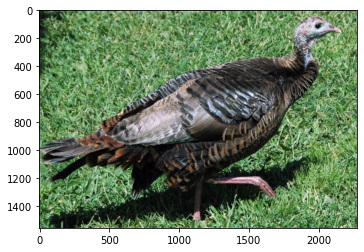

In [14]:
# Display the test image
%matplotlib inline
plt.imshow(Image.open("../data/fowl_data/test_img.jpg"))

### Python SDK

Use the Python SDK to send input data to the service endpoint and retrieve prediction results.

In [48]:
# Preprocess the image
input_data = preprocess_image("../data/fowl_data/test_img.jpg")

# Run the service
result = service.run(input_data=json.dumps({"data": input_data.tolist()}))
print(result)

{'label': 'turkey', 'probability': '0.9127065'}


### Send HTTP Request

Send an HTTP request with the Python requests library. This is an example for how any REST API POST operation can retrieve prediction results from the model.

In [54]:
# send a random row from the test set to score
input_data_str = "{\"data\": " + str(input_data.tolist()) + "}"

headers = {"Content-Type": "application/json"}

# For AKS deployment the service key needs to be in the header as well
# api_key = service.get_key()
# headers = {"Content-Type": "application/json", "Authorization":("Bearer "+ api_key)} 

resp = requests.post(service.scoring_uri, input_data_str, headers=headers)

print("POST to url", service.scoring_uri)
print("Result:", resp.text)

POST to url http://eeb8c9ab-e963-4353-a79a-a79f43fc10dc.westeurope.azurecontainer.io/score
Result: {"label": "turkey", "probability": "0.9127065"}


# Resource Clean Up

Delete the web service with a simple API call.

In [55]:
service.delete()

Delete the AKS cluster.

In [56]:
aks_target.delete()

In [ ]:
aks_service_name = "fowl-pytorch-aks-service"

aks_config = AksWebservice.deploy_configuration(collect_model_data=True,
                                                enable_app_insights=True)

aks_webservices = Webservice.list(workspace = ws, compute_type="AKS")

if any(aks_webservice.name == aks_service_name for aks_webservice in aks_webservices):
    print("Model with same name already deployed")
else:
    if aks_target.provisioning_state == "Succeeded":
        service = Webservice.deploy_from_image(workspace = ws,
                                               name = aks_service_name,
                                               image = image,
                                               deployment_config = aks_config,
                                               deployment_target = aks_target)
        
        service.wait_for_deployment(show_output = True)
        print("Service state:", service.state)
        print("Service details:", service)
    else: 
        raise ValueError("Failed to deploy service to AKS - Error: ", service.error)

In [10]:
image_name = "inference/cifar10-pytorch"
image_label = "1.0" # image tag
generate_dockerfile = True # Option 1: False -> Build Image on ACR; Option 2: True -> Only create Dockerfile


# Creating package
package = Model.package(ws, 
                        [model], 
                        inference_config=inference_config, 
                        generate_dockerfile=generate_dockerfile,
                        image_name=image_name,
                        image_label=image_label)

package.wait_for_creation(show_output=True)

Package creation Succeeded


In [ ]:
az aks create \
    --resource-group myResourceGroup \
    --name myAKSCluster \
    --node-count 2 \
    --generate-ssh-keys \
    --attach-acr <acrName>

Log in to Azure CLI:

`az login --tenant 461e2020-109b-4c43-ad3f-eb9944f5dc44`

Install Kubernetes CLI if not already installed.

`sudo az aks install-cli`

Configure kubectl to connect to AKS cluster:

`az aks get-credentials --resource-group amlbrikserg --name aks-clusterc308442648`

Verify the connection to the cluster by listing the cluster nodes:

`kubectl get nodes`

Retrieve ACR login server name (if this command does not work activate a conda environment in the terminal):

`az acr list --resource-group amlbrikserg --query "[].{acrLoginServer:loginServer}" --output table`

Create directory for kubernetes manifest file.

In [11]:
kubernetes_config_dir = os.path.join(os.getcwd(), "../config/kubernetes")
os.makedirs(kubernetes_config_dir, exist_ok=True)
print(f"Environment directory {kubernetes_config_dir} has been created.")

Environment directory /mnt/batch/tasks/shared/LS_root/mounts/clusters/amlbriksevnetci/code/Users/BRIKSE/pytorch-use-cases-azure-ml/template_project/notebooks/../config/kubernetes has been created.


In [12]:
%%writefile ../config/kubernetes/cifar10_pytorch.yml
apiVersion: apps/v1
kind: Deployment
metadata:
  name: cifar10-torch-image-classifier
spec:
  replicas: 1
  selector:
    matchLabels:
      app: cifar10-torch-image-classifier
  strategy:
    rollingUpdate:
      maxSurge: 1
      maxUnavailable: 1
  minReadySeconds: 5 
  template:
    metadata:
      labels:
        app: cifar10-torch-image-classifier
    spec:
      nodeSelector:
        "beta.kubernetes.io/os": linux
      containers:
      - name: cifar10-torch-image-classifier
        image: 3d5545b15c4c49548d3823156fa90536.azurecr.io/cifar10-pytorch:1.0
        ports:
        - containerPort: 80
        resources:
          requests:
            cpu: 250m
          limits:
            cpu: 500m
---
apiVersion: v1
kind: Service
metadata:
  name: cifar10-torch-image-classifier
spec:
  type: LoadBalancer
  ports:
  - port: 80
  selector:
    app: cifar10-torch-image-classifier

Overwriting ../config/kubernetes/cifar10_pytorch.yml


Deploy the application. Run below command from the project root directory. Below command parses the manifest file and creates the defined Kubernetes objects:

`kubectl apply -f config/kubernetes/cifar10_pytorch.yml`

Test the application and monitor progress:

`kubectl get deployment cifar10-torch-image-classifier --watch`

After you create a package, you can use package.pull() to pull the image to your local Docker environment. This can only be used if `generate_dockerfile` is set to `False`. When the package is pulled, use the `docker images` command to list the local images.

In [46]:
# package.pull()

To start a local container based on this image, use the following command to start a named container from the shell or command line. Replace the `<imageid>` value with the image ID returned by the docker images command.

`docker run -p 6789:5001 --name mycontainer <imageid>`

This command starts the latest version of the image named `myimage`. It maps local port 6789 to the port in the container on which the web service is listening (5001). It also assigns the name mycontainer to the container, which makes the container easier to stop. After the container is started, you can submit requests to http://localhost:6789/score.

After you create a Dockerfile, you can use package.save() to download the Dockerfile and corresponding artifacts to your local machine. This can only be used if `generate_dockerfile` is set to `True`.

In [47]:
acr = package.get_container_registry()
print("Address:", acr.address)
print("Username:", acr.username)
print("Password:", acr.password)

Address: eafc0c3ef9714c74a4fa655ee90531ba.azurecr.io
Username: eafc0c3ef9714c74a4fa655ee90531ba
Password: QYPVrNglB0VvrUrEVMhWar5U4wT4G/tP


In [48]:
package.save("../environments/docker/")

Logging into Docker registry eafc0c3ef9714c74a4fa655ee90531ba.azurecr.io


## Local Image Build

In [20]:
#!docker login <address> -u <username> -p <password>
#!cd environments/docker
#!docker build --tag cifar10-pytorch <imagefiles> 
#!docker images

In [21]:
# Remove docker images
#!docker image rm <image_id>

## Local Image Deployment

In [22]:
#!docker run -p 6789:5001 --name cifar10-pytorch-container cifar10-pytorch:latest

## Push Image to ACR

In [ ]:
# Tag image with fully qualified path
#!docker tag cifar10-pytorch 5c5bd98e724841e884500ebf807070c9.azurecr.io/inference/cifar10-pytorch
# Push image
#!docker push 5c5bd98e724841e884500ebf807070c9.azurecr.io/inference/cifar10-pytorch

In [ ]:
#!az acr build --image inference/acrtasktest:1.0 --registry eafc0c3ef9714c74a4fa655ee90531ba .

## Option 2: Deploy to Compute Target

### Azure Kubernetes Service

### Option 1: Azure Container Instances

The next cell deploys the model to an Azure Container Instance so that you can score data in real-time (Azure Machine Learning also provides mechanisms to do batch scoring). A real-time endpoint allows application developers to integrate machine learning into their apps.


In [13]:
aci_config = AciWebservice.deploy_configuration(cpu_cores=1,
                                                memory_gb=1,
                                                tags={"data": "Cifar",  "method" : "Pytorch"},
                                                description="Predict cifar images with a Pytorch CNN")

In [15]:
service_name = "cifar-prediction-service"

service = Model.deploy(workspace=ws,
                       name=service_name,
                       models=[model],
                       inference_config=inference_config,
                       deployment_config=aci_config,
                       overwrite=True)
service.wait_for_deployment(show_output=True)

Tips: You can try get_logs(): https://aka.ms/debugimage#dockerlog or local deployment: https://aka.ms/debugimage#debug-locally to debug if deployment takes longer than 10 minutes.
Running...............................................................
Succeeded
ACI service creation operation finished, operation "Succeeded"


In [16]:
print(service.scoring_uri)

http://9f464353-ae45-45be-b801-5112e33cafe2.westeurope.azurecontainer.io/score


## Option 2: Attaching

In [ ]:
aks_target_name = "newaksinf04"
aks_target = AksCompute(workspace=ws, name=aks_target_name)
print(aks_target.get_status())

In [ ]:
aks_service_name ="newendpoint06"
aks_config = AksWebservice.deploy_configuration(cpu_cores = 1, memory_gb = 4)

In [ ]:
%%time
aks_service = Model.deploy(workspace=ws,
                           name=aks_service_name,
                           models=[model],
                           inference_config=inference_config,
                           deployment_config=aks_config,
                           deployment_target=aks_target)

aks_service.wait_for_deployment(show_output = True)
print(aks_service.state)

# Data

In [23]:
# Define transformation steps
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # mean, variance of channels

# Create test dataset and dataloader
testset = torchvision.datasets.CIFAR10(root="../data", train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified


# Model Testing

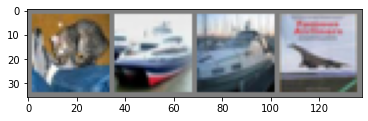

GroundTruth: 
        cat        ship        ship       plane


In [24]:
def imshow(img):
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # transpose dimensions from Pytorch format to default numpy format
    plt.show()
    
# Define classes
classes = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")

dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print("GroundTruth: ", " ".join("%11s" % classes[labels[j]] for j in range(4)), sep="\n")

In [30]:
import json

input_payload = json.dumps({
    "data": images.tolist()
})

output = service.run(input_payload)
print(output)

{"predictions": ["ship", "ship", "ship", "ship"]}


## Test Local Container

In [25]:
import requests
import json

# URL for the web service.
scoring_uri = "http://localhost:6789/score"

input_payload = json.dumps({
    "data": images.tolist()
})

# Set the content type.
headers = {'Content-Type': 'application/json'}

# Make the request and display the response.
resp = requests.post(scoring_uri, input_payload, headers=headers)
print(resp.text)

"{\"predictions\": [\"cat\", \"car\", \"plane\", \"plane\"]}"


In [ ]:
!#docker kill cifar10-pytorch-container

In [ ]:
%%time
env = Environment.get(workspace=ws, name="pytorch-aml-env")

inference_config = InferenceConfig(entry_script="deployment/score.py",
                                   environment=env)

service_name = "Cifar-pytorch-service" + str(uuid.uuid4())[:4]

service = Model.deploy(workspace=ws, 
                       name=service_name, 
                       models=[model], 
                       inference_config=inference_config, 
                       deployment_config=aci_config)

service.wait_for_deployment(show_output=True)

# Test the model

In [ ]:
from utils import load_data
import os
import glob

data_folder = os.path.join(os.getcwd(), 'data')
# note we also shrink the intensity values (X) from 0-255 to 0-1. This helps the neural network converge faster
X_test = load_data(glob.glob(os.path.join(data_folder,"**/t10k-images-idx3-ubyte.gz"), recursive=True)[0], False) / 255.0
y_test = load_data(glob.glob(os.path.join(data_folder,"**/t10k-labels-idx1-ubyte.gz"), recursive=True)[0], True).reshape(-1)

In [ ]:
import os
from azureml.core import Dataset
from azureml.opendatasets import MNIST

data_folder = os.path.join(os.getcwd(), 'data')
os.makedirs(data_folder, exist_ok=True)

mnist_file_dataset = MNIST.get_file_dataset()
mnist_file_dataset.download(data_folder, overwrite=True)

In [ ]:
import json
test = json.dumps({"data": X_test.tolist()})
test = bytes(test, encoding='utf8')
y_hat = service.run(input_data=test)

In [ ]:
from sklearn.metrics import confusion_matrix

conf_mx = confusion_matrix(y_test, y_hat)
print(conf_mx)
print('Overall accuracy:', np.average(y_hat == y_test))

In [ ]:
# normalize the diagonal cells so that they don't overpower the rest of the cells when visualized
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)

fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111)
cax = ax.matshow(norm_conf_mx, cmap=plt.cm.bone)
ticks = np.arange(0, 10, 1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(ticks)
ax.set_yticklabels(ticks)
fig.colorbar(cax)
plt.ylabel('true labels', fontsize=14)
plt.xlabel('predicted values', fontsize=14)
plt.savefig('conf.png')
plt.show()

In [ ]:
import json

# find 30 random samples from test set
n = 30
sample_indices = np.random.permutation(X_test.shape[0])[0:n]

test_samples = json.dumps({"data": X_test[sample_indices].tolist()})
test_samples = bytes(test_samples, encoding='utf8')

# predict using the deployed model
result = service.run(input_data=test_samples)

# compare actual value vs. the predicted values:
i = 0
plt.figure(figsize = (20, 1))

for s in sample_indices:
    plt.subplot(1, n, i + 1)
    plt.axhline('')
    plt.axvline('')
    
    # use different color for misclassified sample
    font_color = 'red' if y_test[s] != result[i] else 'black'
    clr_map = plt.cm.gray if y_test[s] != result[i] else plt.cm.Greys
    
    plt.text(x=10, y =-10, s=result[i], fontsize=18, color=font_color)
    plt.imshow(X_test[s].reshape(28, 28), cmap=clr_map)
    
    i = i + 1
plt.show()

In [ ]:
service.delete()

Now, you're ready to deploy the model as a web service in [Azure Container Instances](https://docs.microsoft.com/azure/container-instances/) (ACI). A web service is an image, in this case a Docker image, that encapsulates the scoring logic and the model itself. 

ACI is a great solution for testing and understanding the workflow. For scalable production deployments, consider using Azure Kubernetes Service.

In [ ]:
#### Install Homomorphic Encryption based library for Secure Inferencing

Our library is based on [Microsoft SEAL](https://github.com/Microsoft/SEAL) and pubished to [PyPi.org](https://pypi.org/project/encrypted-inference) as an easy to use package 

In [ ]:
# !pip install encrypted-inference==0.9

In [ ]:
%%writefile score.py
import json
import os
import pickle
import joblib
from azure.storage.blob import BlobServiceClient, BlobClient, ContainerClient, PublicAccess
from encrypted.inference.eiserver import EIServer

def init():
    global model
    # AZUREML_MODEL_DIR is an environment variable created during deployment.
    # It is the path to the model folder (./azureml-models/$MODEL_NAME/$VERSION)
    # For multiple models, it points to the folder containing all deployed models (./azureml-models)
    model_path = os.path.join(os.getenv('AZUREML_MODEL_DIR'), 'sklearn_mnist_model.pkl')
    model = joblib.load(model_path)

    global server
    server = EIServer(model.coef_, model.intercept_, verbose=True)

def run(raw_data):

    json_properties = json.loads(raw_data)

    key_id = json_properties['key_id']
    conn_str = json_properties['conn_str']
    container = json_properties['container']
    data = json_properties['data']

    # download the Galois keys from blob storage
    #TODO optimize by caching the keys locally  
    blob_service_client = BlobServiceClient.from_connection_string(conn_str=conn_str)
    blob_client = blob_service_client.get_blob_client(container=container, blob=key_id)
    public_keys = blob_client.download_blob().readall()
    
    result = {}
    # make prediction
    result = server.predict(data, public_keys)

    # you can return any data type as long as it is JSON-serializable
    return result

In [ ]:
### Predict test data

Feed the test dataset to the model to get predictions.


The following code goes through these steps:

1. Create our Homomorphic Encryption based client 

1. Upload HE generated public keys 

1. Encrypt the data

1. Send the data as JSON to the web service hosted in ACI. 

1. Use the SDK's `run` API to invoke the service. You can also make raw calls using any HTTP tool such as curl.

In [ ]:
#### Create our Homomorphic Encryption based client 

Create a new EILinearRegressionClient and setup the public keys 

In [ ]:
from encrypted.inference.eiclient import EILinearRegressionClient

# Create a new Encrypted inference client and a new secret key.
edp = EILinearRegressionClient(verbose=True)

public_keys_blob, public_keys_data = edp.get_public_keys()


In [ ]:
#### Upload HE generated public keys

Upload the public keys to the workspace default blob store. This will allow us to share the keys with the inference server

In [ ]:
import azureml.core
from azureml.core import Workspace, Datastore
import os

ws = Workspace.from_config()

datastore = ws.get_default_datastore()
container_name=datastore.container_name

# Create a local file and write the keys to it
public_keys = open(public_keys_blob, "wb")
public_keys.write(public_keys_data)
public_keys.close()

# Upload the file to blob store
datastore.upload_files([public_keys_blob])

# Delete the local file
os.remove(public_keys_blob)

In [ ]:
#### Encrypt the data 

In [ ]:
#choose any one sample from the test data 
sample_index = 1

#encrypt the data
raw_data = edp.encrypt(X_test[sample_index])


In [ ]:
#### Send the test data to the webservice hosted in ACI

Feed the test dataset to the model to get predictions. We will need to send the connection string to the blob storage where the public keys were uploaded 


In [ ]:
import json
from azureml.core import Webservice

service = Webservice(ws, service_name)

#pass the connection string for blob storage to give the server access to the uploaded public keys 
conn_str_template = 'DefaultEndpointsProtocol={};AccountName={};AccountKey={};EndpointSuffix=core.windows.net'
conn_str = conn_str_template.format(datastore.protocol, datastore.account_name, datastore.account_key)

#build the json 
data = json.dumps({"data": raw_data, "key_id" : public_keys_blob, "conn_str" : conn_str, "container" : container_name })
data = bytes(data, encoding='ASCII')

print ('Making an encrypted inference web service call ')
eresult = service.run(input_data=data)

print ('Received encrypted inference results')

In [ ]:
#### Decrypt the data

Use the client to decrypt the results

In [ ]:
import numpy as np 

results = edp.decrypt(eresult)

print ('Decrypted the results ', results)

#Apply argmax to identify the prediction result
prediction = np.argmax(results)

print ( ' Prediction : ', prediction)
print ( ' Actual Label : ', y_test[sample_index])

In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [ ]:
import json

input_payload = json.dumps({
    'data': images.tolist()
})

output = service.run(input_payload)
print(output)

It is often the case that once you have your machine learning code working in a development environment that you want to productionize this by running as a **_job_** - ideally on a schedule or trigger (for example, arrival of new data).